In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Libraries

In [2]:
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

import itertools, os, shutil, random, glob

import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [3]:
train_path = '/kaggle/input/cat-and-dog/training_set/training_set'
# valid_path = 'data/dogs-vs-cats/valid'
test_path = '../input/cat-and-dog/test_set/test_set'

In [4]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(64,64), classes=['cats', 'dogs'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(64,64), classes=['cats', 'dogs'], batch_size=10, shuffle=False)

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


1. <font color='red'>ImageDataGenerator.flow_from_directory()</font> creates a DirectoryIterator, which generates batches of normalized tensor image data from the respective data directories.
2. Notice, to ImageDataGenerator for each of the data sets, we specify <font color='red'>preprocessing_function=tf.keras.applications.vgg16.preprocess_input</font>. For now, just understand this does an additional processing step on the images. We'll cover what exactly this processing is when we work with the pre-trained VGG16 CNN in a future episode.
3. To <font color = 'red'>flow_from_directory()</font>, we first specify the path for the data. We then specify the target_size of the images, which will resize all images to the specified size. The size we specify here is determined by the input size that the neural network expects.
4. The <font color = 'red'>classes</font> parameter expects a list that contains the underlying class names, and lastly, we specify the batch_size.
5. We also specify <font color = 'red'>shuffle=False</font> only for <font color = 'red'>test_batches</font>. That's because, later when we plot the evaluation results from the model to a <font color = 'red'>confusion matrix</font>,we'll need to able to access the unshuffled labels for the test set. By default, the data sets are shuffled
6. <font color = 'blue'>Note, in the case where you do not know the labels for the test data, you will need to modify the `test_batches` variable. Specifically, the change will be to set the parameters `classes = None` and `class_mode = None` in `flow_from_directory()`.</font>

# Visualize the data

We now call `next(train_batches)` to generate a batch of images and labels from the training set. Note that the size of this batch is determined by the `batch_size` we set when we created `train_batches`.

### <font color = 'green'>Preparing the Train Data</font>

In [5]:
imgs, labels = next(train_batches)

We then use this plotting function obtained from `TensorFlow's documentation` to plot the processed images within our Jupyter notebook.

In [6]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

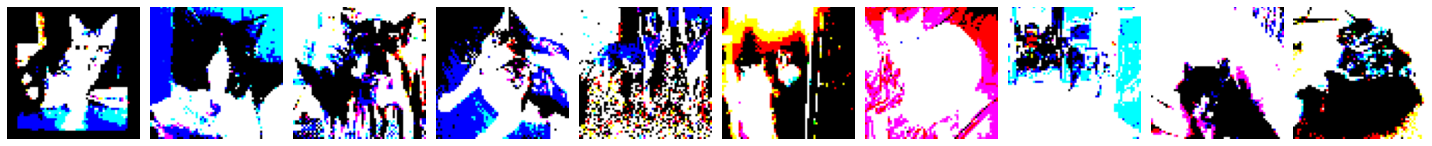

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [7]:
plotImages(imgs)
print(labels)

This is what the first processed random batch from the training set looks like. Notice that the color appears to be distorted. This has to do with the VGG16 processing we applied to the data sets, which we'll talk about in few minutes. Don't worry about it for now, just know that the RGB pixel data has been processed in such a way that the image data now looks like this before being passed to the network.

Note that dogs are represented with the `one-hot encoding` of `[0,1]`, and cats are represented by `[1,0]`

We’re now all set up to work with this data!, we’ll now use this data to train a convolutional neural network.

# Build A Simple CNN

In [8]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(64,64,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

The first layer in the model is a 2-dimensional convolutional layer. This layer will have `32` output filters each with a kernel size of `3x3`, and we’ll use the `relu` activation function.

Note that the choice for the number of output filters specified is arbitrary, and the chosen kernel size of `3x3` is generally a very common size to use. You can experiment by choosing different values for these parameters.

We enable zero-padding by specifying `padding = 'same'`.

On the first layer only, we also specify the `input_shape`, which is the shape of our data. Our images are `224` pixels high and `224` pixels wide and have `3` color channels: RGB. This gives us an `input_shape` of `(224,224,3)`.

We then add a `max pooling` layer to pool and reduce the dimensionality of the data.

We follow this by adding another convolutional layer with the exact specs as the earlier one, except for this second `Conv2D` layer has `64` filters. The choice of 64 here is again arbitrary, but the general choice of having more filters in later layers than in earlier ones is common. This layer is again followed by the same type of `MaxPool2D` layer

We then `Flatten` the output from the convolutional layer and pass it to a `Dense` layer. This `Dense` layer is the output layer of the network, and so it has `2` nodes, one for cat and one for dog. We’ll use the `softmax` activation function on our output so that the output for each sample is a probability distribution over the outputs of cat and dog.

We can check out a summary of the model by calling `model.summary()`.

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 32770     
Total params: 52,162
Trainable params: 52,162
Non-trainable params: 0
____________________________________________________

Now that the model is built, we `compile` the model using the `Adam optimizer` with a learning rate of `0.0001`, a loss of `categorical_cross_entropy`, and we’ll look at `accuracy` as our performance metric. 

In [10]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

Note that when we have only two classes, we could instead configure our output layer to have only one output, rather than two, and use `binary_crossentropy` as our loss, rather than `categorical_crossentropy`. Both options work equally well and achieve the exact same result.

With `binary_crossentropy`, however, the last layer would need to use <font color='orange'>sigmoid</font>, rather than <font color='dark pink'>softmax</font>, as its activation function.

# Train A Simple CNN

Now it’s time to train the model.

We've already introduced the `model.fit()` function to train a model in above cells. We'll be using it in the same fashion here, except for now, we'll be passing in our newly introduced `DirectoryIterators` `train_batches`to train the model.

In [11]:
model.fit(x=train_batches, epochs=5, verbose=2)

Epoch 1/5
801/801 - 86s - loss: 3.2267 - accuracy: 0.6112
Epoch 2/5
801/801 - 58s - loss: 1.0453 - accuracy: 0.6946
Epoch 3/5
801/801 - 57s - loss: 0.6096 - accuracy: 0.7558
Epoch 4/5
801/801 - 56s - loss: 0.4381 - accuracy: 0.8086
Epoch 5/5
801/801 - 56s - loss: 0.3279 - accuracy: 0.8581


We’re specifying `5` as the number of `epochs` we’d like to run, and setting the `verbose` parameter to `2`, which just specifies the verbosity of the log output printed to the console during training.

From this output, we can see the performance of this simple model on the training set is great, with accuracy reaching almost 100% and loss nearing almost 0,we can see that our model is vastly overfitting the training data.

At this point, we could continue to work on this model to combat overfitting, or we could try another approach of using a pre-trained model on this data. We'll explore the latter in the upcoming cells.

# Make Predictions With A Keras CNN Image Classifier

### <font color = 'green'>Preparing the Test Data</font>

We’ll now run `next(test_batches)` to extract a batch of images and their corresponding labels from the test set.

In [12]:
test_imgs, test_labels = next(test_batches)

Using the `plotImages()` function we previously introduced, we can see what this batch of test data looks like

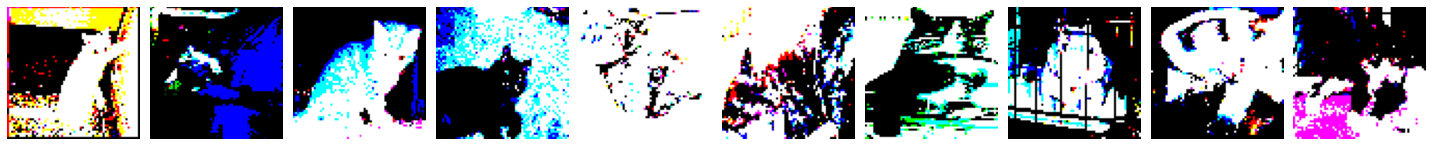

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [13]:
plotImages(test_imgs)
print(test_labels)

Just as we saw before, cats are labeled with a one-hot encoding of `[1,0]`, and dogs are labeled as `[0,1]`.

Note, because we chose to not shuffle our test set when we originally created it, the first half of the test data is all cats, and the second half is all dogs. Also, recall that the color data appears skewed due to the VGG16 preprocessing we specified when we created the data sets.

# Predicting On The Test Data

Now we’ll use our previously built model and call model.predict() to have the model predict on the test set.

In [14]:
predictions = model.predict(x=test_batches, verbose=0)

We pass in the test set, `test_batches`, and set `verbose=0` to see no output during the evaluation process.

After running the predictions, we can print our the rounded predictions see what they look like.

In [15]:
np.round(predictions)

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

These are the labels that the model is predicting for our images.

# Plotting Predictions With A Confusion Matrix

To get a better visualization of these results, we’ll plot them in a confusion matrix.

We create the confusion matrix using `scikit-learn`

In [27]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

To the confusion matrix, we pass the true labels of the test set, along with the predicted labels for the test set from the model.

Note, we can access the unshuffled true labels for the test set by calling `test_batches.classes`.

We transform the one-hot encoded predicted labels to be in the same format as the true labels by only selecting the element with the highest value for each prediction using `np.argmax(predictions, axis=-1)`.

In [29]:
cm

array([[721, 290],
       [305, 707]])

We now use the plot_confusion_matrix() function that is copied directly from scikit-learn

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

We can then inspect the `class_indices` for the labels so that we know in which order to pass them to our confusion matrix.

In [31]:
test_batches.class_indices

{'cats': 0, 'dogs': 1}

#### Finally, we plot the confusion matrix.

Confusion matrix, without normalization
[[721 290]
 [305 707]]


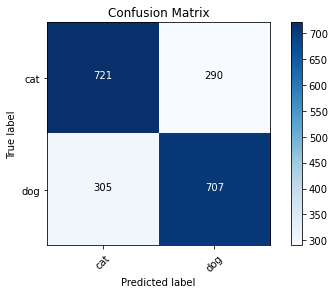

In [32]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# CV for CNN

In [ ]:
no_classes = 100
no_epochs = 5

# optimizer = Adam()
verbosity = 1
num_folds = 5

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(imgs, labels):

  # Define the model architecture
    model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(64,64,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')])

  # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy', metrics=['accuracy'])


  # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

  # Fit data to model
    history = model.fit(x=train_batches, epochs=5, verbose=2)

  # Generate generalization metrics
    scores = model.evaluate(imgs[test], labels[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

  # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/5
801/801 - 55s - loss: 2.8673 - accuracy: 0.5968
Epoch 2/5
801/801 - 53s - loss: 0.9630 - accuracy: 0.6760
Epoch 3/5
801/801 - 55s - loss: 0.5956 - accuracy: 0.7457
Epoch 4/5
801/801 - 56s - loss: 0.4405 - accuracy: 0.8045
Epoch 5/5
801/801 - 53s - loss: 0.3365 - accuracy: 0.8516
Score for fold 1: loss of 0.01629374921321869; accuracy of 100.0%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/5
801/801 - 54s - loss: 2.7724 - accuracy: 0.6049
Epoch 2/5
801/801 - 54s - loss: 0.8332 - accuracy: 0.6882
Epoch 3/5
